### Maximum Likelihood tree inference

Sequences generated in for this study are in the following files:

 - `sequences/Gammarus_sp_SANGER.fasta` #Sanger sequences
 - `../3-extract_haplotypes/Gammarus_sp_from_metaBEAT.fasta` #haplotyes extracted from metabarcoding data
 
Other Gammarid COI sequences from Weiss et al. 2014 are at:
 - `../1-download_reference/Gammarus_COI_Weiss_et_al_2013.gb`

Find the Reprophylo manual [here](https://docs.google.com/document/d/1Q-8B0cvkZw2zMkuP0Af4zZ7FiAvBQPDdGbrLLMgtx_4/edit#).

Import reprophylo functions.

In [1]:
from reprophylo import *

Specifying the locus/loci to be used in the analyses.

The Genbank input files may contain sequences for a range of genes (say you have downloaded full mitochondrial genomes), but you are only interested in a particular gene (say COI). 

So, first we'll want to get an overview of all the genes present in your input Genbank file. Reprophylo has a function for that.

The function will write tentative locus descriptions to the file `loci.csv`, which you may modify, e.g. exclude certain genes from the loci file, or synonymize gene names if necessary.

In [2]:
list_loci_in_genbank('../1-download_reference/Gammarus_COI_Weiss_et_al_2013.gb', 'loci.csv')


There are 2 gene names (or gene product names) detected
----------------------------------
Gene and count sorted by gene name
----------------------------------
63 instances of CDS,COI
3 instances of CDS,cytochrome c oxidase subunit I
-------------------------------
Gene and count sorted by counts
-------------------------------
63 instances of CDS,COI
3 instances of CDS,cytochrome c oxidase subunit I


The function finds 2 unique gene names. Reprophylo internally contains a list of synoyms for common genes and in this case understands that the two gene names are synonymous. The tentative list of loci that it produces in the file `loci.csv` thus contains only a description for one locus.

In [3]:
!cat loci.csv

dna,CDS,MT-CO1,COI,cytochrome c oxidase subunit I


Start a new Reprophylo project, specifying/characterizing the loci to be processed via the `loci.csv` file that we have prepared.

In [4]:
pj = Project('loci.csv', pickle='my_project.pickle', git=False)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


Check if the Reprophylo project was created correctly.

In [5]:
print pj

Project object with the loci MT-CO1,


Reading in the sequences from Weiss et al. 2013 from Genbank format.

In [6]:
input_files=['../1-download_reference/Gammarus_COI_Weiss_et_al_2013.gb']
pj.read_embl_genbank(input_files)

/home/reprophylo/reprophylo.py:1015: UserWarning: Version control off
  warnings.warn('Version control off')


All sequences are now stored in memory as 'sequence records'. 

How many sequences does our dataset contain?

In [7]:
print len(pj.records)

66


Reading in the new sequences produced from Sanger sequencing or metabarcoding. They will be added to the sequence records with the id 'denovo'

In [8]:
denovo_sequence_filenames=['sequences/Gammarus_sp_SANGER.fasta', 
 '../3-extract_haplotypes/Gammarus_sp_from_metaBEAT.fasta']

pj.read_denovo(denovo_sequence_filenames, 'dna', format='fasta')

8

In [9]:
print len(pj.records)

74


We are assuming that the sequences that came from Genbank are already in the correct orientation, but we should check that our custom sequences need to be inverted. 

We'll use the `blast` program and a few functions to do that.

Install the `blast` program.

In [10]:
!apt-get install ncbi-blast+

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ncbi-blast+ is already the newest version.
0 upgraded, 0 newly installed, 0 to remove and 287 not upgraded.


In [11]:
!mkdir temp

In [12]:
from Bio import SeqIO

output_handle = open("temp/test.fasta", "w")
SeqIO.write(pj.records, output_handle, "fasta")
output_handle.close()

In [13]:
!makeblastdb -in temp/test.fasta -dbtype nucl -out temp/all



Building a new DB, current time: 09/21/2016 00:45:20
New DB name:   temp/all
New DB title:  temp/test.fasta
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 74 sequences in 0.00287414 seconds.


In [14]:
!blastn -db temp/all -query temp/test.fasta -outfmt '6 qseqid sseqid qstart qend sstart send' -out temp/test.blastn.out

Identify any denovo sequences that match with non-denovo sequences in reverse complement.

In [15]:
blastout=open('temp/test.blastn.out')

to_invert=[]
for line in blastout:
    col=line.split("\t")
    if (col[-2] > col[-1]) and ('denovo' in col[0]) and (not 'denovo' in col[1]):
        to_invert.append(col[0])
        
to_invert=list(set(to_invert))
print "Records to invert:\n%s" %to_invert

blastout.close()

Records to invert:
['denovo0', 'denovo1', 'denovo2', 'denovo3', 'denovo4', 'denovo5']


Reverse complement records.

In [16]:
if to_invert:
    print "There are records to invert\n"
    for r in pj.records:
        if r.id in to_invert:
            print "\t-> %s" %r.id
            r.seq = r.seq.reverse_complement()
            to_invert.remove(r.id)
else:
    print "Nothing to invert\n"

There are records to invert

	-> denovo0
	-> denovo1
	-> denovo2
	-> denovo3
	-> denovo4
	-> denovo5


Remove temporal directory.

In [17]:
!rm -rf temp

Now, lets print a summary of the number of sequences per species.

In [18]:
pj.species_vs_loci('species.csv')

In [19]:
!cat species.csv

Some sequences seem to be missing. This is because the `species_by_loci` function. Only considers sequence records that are identified with the correct gene identifier. We need to add this for our custom sequences so that reprophylo understands that these sequences are to be analysed together with the COI sequences that we have loaded from the Genbank data.

In [20]:
for r in pj.records:
    if 'denovo' in r.id:
        pj.add_feature_to_record(r.id, 'CDS', qualifiers={'gene': 'MT-CO1'})

In [21]:
pj.species_vs_loci('species.csv')

In [22]:
!cat species.csv

Better, but our custom sequences are now assigned to an undefied species. We'll need to add the species to the record. We will look in the original header of the sequence for the species name and add the appropriate organism name to the sequence record.

In [23]:
for r in pj.records:
    source=r.features[0]
    if 'denovo' in r.id:
        if 'pulex' in source.qualifiers['original_id'][0]:
            r.features[0].qualifiers['organism'] = ['Gammarus pulex']
        elif 'fossarum' in source.qualifiers['original_id'][0]:
            r.features[0].qualifiers['organism'] = ['Gammarus fossarum']


In [24]:
pj.species_vs_loci('species.csv')

In [25]:
!cat species.csv

There! Now, let's produce some stats for the sequences in our dataset.

In [26]:
pj.extract_by_locus()

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


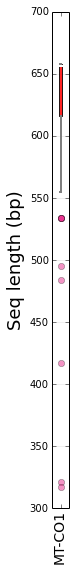

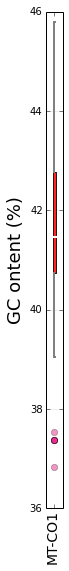

In [27]:
%matplotlib inline
pj.report_seq_stats()


Configure sequence alignment with mafft.

In [28]:
mafft_linsi = AlnConf(pj, 
                      method_name='mafftLinsi', 
                      CDSAlign=False, 
                      program_name='mafft', 
                      cmd='mafft', 
                      loci=['MT-CO1'], 
                      cline_args={'localpair': True, 'maxiterate': 1000})

mafft --localpair --maxiterate 1000 840991474418721.95_MT-CO1.fasta


Execute sequence alignment process.

In [29]:
pj.align([mafft_linsi])

Display information about the alignment method.

In [30]:
print pj.used_methods['mafftLinsi']

AlnConf named mafftLinsi with ID 840991474418721.95
Loci: MT-CO1 
Created on: Wed Sep 21 00:45:21 2016
Commands:
MT-CO1: mafft --localpair --maxiterate 1000 840991474418721.95_MT-CO1.fasta

Environment:
Platform: Linux-3.13.0-54-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: chrishah-office
 Program and version: MAFFT v7.123b
 Program reference:Katoh
 Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multiple sequence alignment software version 7: improvements in performance and usability.
execution time:
10.5745439529


Core Methods section sentence:
The dataset(s) MT-CO1 were aligned using the program MAFFT v7.123b [1].

Reference:
Katoh, Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multi

Write alignment to file for checking in e.g. `Aliview`.

In [31]:
pj.write_alns(id=['record_id', 'source_organism'], format='fasta')

['MT-CO1@mafftLinsi_aln.fasta']

The sequences in our alignment are of different lengths. Sequences obtained via eDNA metabarcoding approach are shorter (~313bp). To explore the effect of different algnment trimming settings we'll trim the alignemnt with  different paramters to keep only columns that are present in more than 70, 80, 90, 95 and 99% of samples. 

Configure alignemnt trimming.

Keep columns which are at least 70% complete.

In [32]:
gt70trimal = TrimalConf(pj, method_name='gt70', program_name='trimal', cmd='trimal', alns=['MT-CO1@mafftLinsi'], trimal_commands={'gt': 0.7})

trimal -in 875621474418732.68_MT-CO1@mafftLinsi.fasta -gt 0.7


Keep columns which are at least 80% complete.

In [33]:
gt80trimal = TrimalConf(pj, method_name='gt80', program_name='trimal', cmd='trimal', alns=['MT-CO1@mafftLinsi'], trimal_commands={'gt': 0.8})

trimal -in 314651474418732.69_MT-CO1@mafftLinsi.fasta -gt 0.8


Keep columns which are at least 90% complete.

In [34]:
gt90trimal = TrimalConf(pj, method_name='gt90', program_name='trimal', cmd='trimal', alns=['MT-CO1@mafftLinsi'], trimal_commands={'gt': 0.9})

trimal -in 197301474418732.71_MT-CO1@mafftLinsi.fasta -gt 0.9


Keep columns which are at least 95% complete.

In [35]:
gt95trimal = TrimalConf(pj, method_name='gt95', program_name='trimal', cmd='trimal', alns=['MT-CO1@mafftLinsi'], trimal_commands={'gt': 0.95})

trimal -in 876601474418732.73_MT-CO1@mafftLinsi.fasta -gt 0.95


Keep columns which are at least 99% complete.

In [36]:
gt99trimal = TrimalConf(pj, method_name='gt99', program_name='trimal', cmd='trimal', alns=['MT-CO1@mafftLinsi'], trimal_commands={'gt': 0.99})

trimal -in 954261474418732.76_MT-CO1@mafftLinsi.fasta -gt 0.99


Execute alignemnt trimming.

In [37]:
pj.trim([gt70trimal,gt80trimal,gt90trimal,gt95trimal,gt99trimal])

In [38]:
print pj.used_methods['gt70']

TrimalConf named gt70 with ID 875621474418732.68
Alignments: MT-CO1@mafftLinsi 
Created on: Wed Sep 21 00:45:32 2016
Commands:
MT-CO1@mafftLinsi@gt70: trimal -in 875621474418732.68_MT-CO1@mafftLinsi.fasta -gt 0.7

Environment:Platform: Linux-3.13.0-54-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: chrishah-office
 Program and version: trimAl 1.2rev59
 Program reference: Salvador Capella-Gutierrez; Jose M. Silla-Martinez; Toni Gabaldon. trimAl: a tool for automated alignment trimming in large-scale phylogenetic analyses. Bioinformatics 2009 25: 1972-1973.
execution time:
0.386928081512

Core Methods section sentence:
The alignment(s) MT-CO1@mafftLinsi were trimmed using the program trimAl 1.2rev59 [1].

Reference:
Salvador Ca

In [39]:
pj.write_trimmed_alns(id=['record_id', 'source_organism'], format='fasta')

['MT-CO1@mafftLinsi@gt70_trimmed_aln.fasta',
 'MT-CO1@mafftLinsi@gt80_trimmed_aln.fasta',
 'MT-CO1@mafftLinsi@gt90_trimmed_aln.fasta',
 'MT-CO1@mafftLinsi@gt99_trimmed_aln.fasta',
 'MT-CO1@mafftLinsi@gt95_trimmed_aln.fasta']

Pickle the project.

In [40]:
pickle_pj(pj, 'my_project.pickle')

'my_project.pickle'

Configure tree building.

In [41]:
print pj.trimmed_alignments

{'MT-CO1@mafftLinsi@gt70': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 639, IUPACAmbiguousDNA()) at 7f72087cf5d0>, 'MT-CO1@mafftLinsi@gt80': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 605, IUPACAmbiguousDNA()) at 7f72087780d0>, 'MT-CO1@mafftLinsi@gt90': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 536, IUPACAmbiguousDNA()) at 7f7208728950>, 'MT-CO1@mafftLinsi@gt99': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 214, IUPACAmbiguousDNA()) at 7f7208767a90>, 'MT-CO1@mafftLinsi@gt95': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 508, IUPACAmbiguousDNA()) at 7f720872d210>}


In [42]:
raxml = RaxmlConf(pj, method_name='mafftLinsi-trimal', 
                 program_name='raxmlHPC-PTHREADS-SSE3',
                 keepfiles=True,
                 cmd='raxmlHPC-PTHREADS-SSE3',
                 preset='fa',
                 alns=['MT-CO1@mafftLinsi@gt70','MT-CO1@mafftLinsi@gt80','MT-CO1@mafftLinsi@gt90','MT-CO1@mafftLinsi@gt95','MT-CO1@mafftLinsi@gt99'],
                 model='GAMMA',
                 threads=4,
                 cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 333791474418734.69_MT-CO1@mafftLinsi@gt700 -p 209 -s 333791474418734.69_MT-CO1@mafftLinsi@gt70.fasta -T 4 -x 227 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 333791474418734.69_MT-CO1@mafftLinsi@gt800 -p 388 -s 333791474418734.69_MT-CO1@mafftLinsi@gt80.fasta -T 4 -x 843 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 333791474418734.69_MT-CO1@mafftLinsi@gt900 -p 356 -s 333791474418734.69_MT-CO1@mafftLinsi@gt90.fasta -T 4 -x 353 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 333791474418734.69_MT-CO1@mafftLinsi@gt990 -p 848 -s 333791474418734.69_MT-CO1@mafftLinsi@gt99.fasta -T 4 -x 270 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 333791474418734.69_MT-CO1@mafftLinsi@gt950 -p 210 -s 333791474418734.69_MT-CO1@mafftLinsi@gt95.fasta -T 4 -x 461 -N 100


Execute tree building.

In [43]:
pj.tree([raxml])

In [44]:
print pj.used_methods['mafftLinsi-trimal']

RaxmlConf named mafftLinsi-trimal with ID 333791474418734.69
Alignments: MT-CO1@mafftLinsi@gt70,MT-CO1@mafftLinsi@gt80,MT-CO1@mafftLinsi@gt90,MT-CO1@mafftLinsi@gt99,MT-CO1@mafftLinsi@gt95 
Created on: Wed Sep 21 00:45:34 2016
Commands:
MT-CO1@mafftLinsi@gt70:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 333791474418734.69_MT-CO1@mafftLinsi@gt700 -p 209 -s 333791474418734.69_MT-CO1@mafftLinsi@gt70.fasta -T 4 -x 227 -N 100
MT-CO1@mafftLinsi@gt80:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 333791474418734.69_MT-CO1@mafftLinsi@gt800 -p 388 -s 333791474418734.69_MT-CO1@mafftLinsi@gt80.fasta -T 4 -x 843 -N 100
MT-CO1@mafftLinsi@gt90:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 333791474418734.69_MT-CO1@mafftLinsi@gt900 -p 356 -s 333791474418734.69_MT-CO1@mafftLinsi@gt90.fasta -T 4 -x 353 -N 100
MT-CO1@mafftLinsi@gt99:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 333791474418734.69_MT-CO1@mafftLinsi@gt990 -p 848 -s 333791474418734.69_MT-CO1@mafftLinsi@gt99.fasta -T 4 -x 270 -N 100
MT-CO1@mafftLins

In [45]:
pickle_pj(pj, 'my_project.pickle')

'my_project.pickle'

Annotate ML trees.

Define outgroups.

In [46]:
!cat species.csv

In [47]:
pj.add_qualifier_from_source('organism')


In [48]:
for species in ['balcanicus', 'duebeni', 'glabratus', 'roeselii', 'tigrinus']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

Specify colors for branchsupport.

In [49]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}


Add a new qualifier 'origin' that contains either 'Sanger' or 'metabarcoding' for the newly generated sequences. Also we add another qualifier 'origin_abr' that contains the symbols * or +, respectively.



In [50]:
for r in pj.records:
    if 'denovo' in r.id:
        ## all the Sanger sequences contain the string 'HCO2198' in the sequence header
        if 'HCO2198' in r.description:
            print r.id
            print "origin -> Sanger"
            for f in r.features:
                f.qualifiers['origin'] = ['Sanger']
                f.qualifiers['origin_abr'] = ['*']
        ## if they are don't contain 'HCO2198' they originate from metabarcoding
        else:
            print r.id
            print "origin -> metabarcoding"
            for f in r.features:
                f.qualifiers['origin'] = ['metabarcoding']
                f.qualifiers['origin_abr'] = ['+']
    #if they are not 'denovo' then they were from a previous study
    else:
#        print r.id
#        print "origin -> previous study"
        for f in r.features:
            f.qualifiers['origin'] = ['']
            f.qualifiers['origin_abr'] = ['']

denovo0
origin -> Sanger
denovo1
origin -> Sanger
denovo2
origin -> Sanger
denovo3
origin -> Sanger
denovo4
origin -> Sanger
denovo5
origin -> Sanger
denovo6
origin -> metabarcoding
denovo7
origin -> metabarcoding


Annotate tree.

Format tree to add symbols * or + to leaf name to indicate 'Sanger' or 'metabarcoding' sequences, respectively.

In [51]:
pj.clear_tree_annotations()
pj.annotate('.', 'mid', 'mid', 
            ['source_organism', 'record_id','origin_abr'], 
            node_support_dict=supports, multifurc=None,
            html='./mafftLinsi-trimal-raxml.html')

In [52]:
!cp *_MT-CO1@mafftLinsi@gt90.png mafftLinsi_trimal-gt90_ML-raxml-symbols.png

In [53]:
!cp *_MT-CO1@mafftLinsi@gt95.png mafftLinsi_trimal-gt95_ML-raxml-symbols.png

Color the tree labels according to origin of the sequences.

In [54]:
leaf_colors = {'Sanger':'red', 'metabarcoding': 'blue'}

In [55]:
pj.clear_tree_annotations()
pj.annotate('.', 'mid', 'mid', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=None,
            leaf_node_color_meta = 'origin', leaf_label_colors = leaf_colors,
            html='./mafftLinsi-trimal-raxml.html')

In [56]:
!cp *_MT-CO1@mafftLinsi@gt90.png mafftLinsi_trimal-gt90_ML-raxml-colors.png

In [57]:
!cp *_MT-CO1@mafftLinsi@gt95.png mafftLinsi_trimal-gt95_ML-raxml-colors.png

Write out a table in csv text format containing all available metadata for all available sequences.

In [58]:
pj.write('metadata.tsv', format='csv')

Pickle the latest version of the project so you can pick it up again later if you need to.

In [60]:
pickle_pj(pj, 'my_project.pickle')

'my_project.pickle'

Crop the initial alignment to the length of the shortest sequence obtained via metabarcoding.

In [62]:
print pj.alignments

{'MT-CO1@mafftLinsi': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 675, IUPACProtein()) at 7f7208bdff10>}


In [63]:
from Bio import AlignIO

aln = pj.fa('MT-CO1@mafftLinsi')

start = 0
end=aln.get_alignment_length()

for r in aln:
    if "_".join(r.id.split("_")[:-1]) in ['denovo6','denovo7']:
#        print r.id,r.seq
        for i in range(len(r.seq)):            
            if r.seq[i] == '-':
#                print i,r.seq[i]
                if i > start:
                    start=i
            elif not r.seq[i] == '-':
#                print "BREAK"
                break
#        print r.id,r.seq
        for i in reversed(range(len(r.seq))):
           
            if r.seq[i] == '-':
#                print i,r.seq[i]
                if i < end:
                    end=i
            elif not r.seq[i] == '-':
#                print "BREAK"
                break
                    
print start,end

mb_clipped_aln = aln[:,start+1:end]


returning alignment object MT-CO1@mafftLinsi
342 653


In [64]:
pj.trimmed_alignments['MT-CO1@mafftLinsi@MBclipped'] = mb_clipped_aln

In [65]:
pj.trimmed_alignments

{'MT-CO1@mafftLinsi@MBclipped': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 310, SingleLetterAlphabet()) at 7f7208599310>,
 'MT-CO1@mafftLinsi@gt70': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 639, IUPACAmbiguousDNA()) at 7f72087cf5d0>,
 'MT-CO1@mafftLinsi@gt80': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 605, IUPACAmbiguousDNA()) at 7f72087780d0>,
 'MT-CO1@mafftLinsi@gt90': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 536, IUPACAmbiguousDNA()) at 7f7208728950>,
 'MT-CO1@mafftLinsi@gt95': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 508, IUPACAmbiguousDNA()) at 7f720872d210>,
 'MT-CO1@mafftLinsi@gt99': <<class 'Bio.Align.MultipleSeqAlignment'> instance (74 records of length 214, IUPACAmbiguousDNA()) at 7f7208767a90>}

Configure raxml.

In [66]:
raxml = RaxmlConf(pj, method_name='mafftLinsi-trimal-MBclipped', 
                 program_name='raxmlHPC-PTHREADS-SSE3',
                 keepfiles=True,
                 cmd='raxmlHPC-PTHREADS-SSE3',
                 preset='fa',
                 alns=['MT-CO1@mafftLinsi@MBclipped'],
                 model='GAMMA',
                 threads=4,
                 cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 278281474446075.77_MT-CO1@mafftLinsi@MBclipped0 -p 648 -s 278281474446075.77_MT-CO1@mafftLinsi@MBclipped.fasta -T 4 -x 147 -N 100


In [67]:
pj.tree([raxml])

In [68]:
pj.clear_tree_annotations()
pj.annotate('.', 'mid', 'mid', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=None,
            leaf_node_color_meta = 'origin', leaf_label_colors = leaf_colors,
            html='./mafftLinsi-trimal-raxml.html')

In [69]:
!cp *_MT-CO1@mafftLinsi@MBclipped.png mafftLinsi_trimal_MBclipped_ML-raxml-colors.png

In [70]:
pickle_pj(pj, 'my_project.pickle')

'my_project.pickle'